# Vision Transformer using Pytorch

In [69]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [70]:
class ImageClassification(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # self.fc1 = nn.Linear(input_dim, 512)
        # self.fc2 = nn.Linear(512, num_classes)
        # self.relu = nn.ReLU()
        self.neuralNetwork=nn.Sequential(nn.Linear(input_dim,512),
                                         nn.ReLU(),
                                         nn.Linear(512,num_classes)
                                        )
                                         
    def forward(self, x):
        return torch.softmax(self.neuralNetwork(x),dim=1)

In [96]:
class VisionTransformer(nn.Module):
    def __init__(self,patch_size,output_dimension,num_of_encoder_layers,embed_dims):
        super().__init__()
        self.patch_size=patch_size
        self.linear_output_dimesnion=output_dimension
        self.num_of_encoder_layers=num_of_encoder_layers
        self.embed_dims=embed_dims
        self.num_heads=8
        # patch extractor
        self.unfold=nn.Unfold(kernel_size=self.patch_size,stride=self.patch_size)

        # making each patch linear
        self.linear=nn.Linear(self.patch_size*self.patch_size*3,output_dimension)
        self.encoder_layer=nn.TransformerEncoderLayer( d_model=self.embed_dims, nhead=self.num_heads, dim_feedforward=2048)
        self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=self.num_of_encoder_layers)

        self.classifier = ImageClassification(self.embed_dims, 10)

    def forward(self,input_image):
        # print(input_image)
        batch_size,channel,height,width=input_image.shape
        patched_image=self.unfold(input_image).permute(0,2,1)
        # print(patched_image.shape)
        linear_embeddings=self.linear(patched_image)
        encoder_output=self.transformer_encoder(linear_embeddings)
        mean_encoder_output=torch.mean(encoder_output,dim=1)
        output = self.classifier(mean_encoder_output)

        return output

In [97]:
# import torch
# import torch.nn as nn

# class VisionTransformer(nn.Module):
#     def __init__(self, patch_size, output_dimension, num_of_encoder_layers, embed_dims, num_heads, num_classes):
#         super().__init__()
#         self.patch_size = patch_size
#         self.linear_output_dimension = output_dimension
#         self.num_of_encoder_layers = num_of_encoder_layers
#         self.embed_dims = embed_dims
#         self.num_heads = num_heads
        
#         # Patch extractor
#         self.unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)

#         # Linear layer to map patches to embeddings
#         self.linear = nn.Linear(self.patch_size * self.patch_size * 3, embed_dims)

#         # Transformer Encoder
#         encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dims, nhead=num_heads, dim_feedforward=2048)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_of_encoder_layers)

#         # Classification head (3-layer neural network)
#         self.classifier = nn.Sequential(
#             nn.Linear(embed_dims, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, input_image):
#         batch_size, channels, height, width = input_image.shape

#         # Extract patches
#         patches = self.unfold(input_image).permute(0, 2, 1)  # [batch_size, num_patches, patch_dim]

#         # Map patches to embeddings
#         embeddings = self.linear(patches)

#         # Rearrange embeddings to [seq_len, batch_size, embed_dims]
#         embeddings = embeddings.view(batch_size, -1, self.embed_dims).permute(1, 0, 2)

#         # Transformer Encoder
#         encoder_output = self.transformer_encoder(embeddings)

#         # Take the mean across patches
#         mean_encoder_output = torch.mean(encoder_output, dim=0)

#         # Classification
#         output = self.classifier(mean_encoder_output)

#         return output


In [98]:
import torchvision
import torch.nn.functional as F
train_data=dataset.CIFAR10(
    'train_data',
    transform=transform,
    target_transform=torchvision.transforms.Compose([
                                 lambda x:torch.LongTensor([x]), # or just torch.tensor
                                 lambda x:F.one_hot(x,10)]),
    # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    train=True,
    download=True
)

test_data=dataset.CIFAR10(
    'test_data',
    train=False,
    download=True,
    transform=transform,
    target_transform=torchvision.transforms.Compose([
                                 lambda x:torch.LongTensor([x]), # or just torch.tensor
                                 lambda x:F.one_hot(x,10)])
)
torch.cuda.set_device(2)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [99]:
BATCH_SIZE=64
train_dataloader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True)
test_dataloader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True)

In [100]:
# sample=next(iter(train_dataloader))
# image=sample[0][0]
# label=sample[1][0]
# import matplotlib.pyplot as plt
# plt.imshow(np.transpose(image,(1,2,0)))

In [101]:
image=image.unsqueeze(0)

In [102]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [104]:
LEARNING_RATE=0.001
EPOCHS=10

import torch.optim as optim
transformer=VisionTransformer(patch_size=4,output_dimension=256,num_of_encoder_layers=4,embed_dims=256)
# ,num_heads=8,num_classes=10)
transformer=transformer.to(device)
image_classifier = ImageClassification(input_dim=256, num_classes=10)
image_classifier.to(device)
cross_entropy_loss=nn.CrossEntropyLoss()
optimizer=optimizer = optim.Adam(list(transformer.parameters()) + list(image_classifier.parameters()), lr=LEARNING_RATE)
# res=transformer.createImagePatches(sample[0])

# def train():
#     for epoch in range(EPOCHS):
#         transformer.train()
#         loss=0
#         for input_data,labels in train_dataloader:
#             input_data,labels=input_data.to(device),labels.to(device)
#             optimizer.zero_grad()
#             output=transformer(input_data)
#             loss=cross_entropy_loss(output,labels)
#             loss.backward()
#             optimizer.step()
#             loss += loss.item() * input_data.size(0)
#         epoch_loss = loss / len(train_dataloader.dataset)
#         print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

def train():
    for epoch in range(EPOCHS):
        transformer.train()
        image_classifier.train()
        epoch_loss = 0
        for input_data, labels in train_dataloader:
            input_data, labels = input_data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = transformer(input_data)
            output = image_classifier(output)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * input_data.size(0)
        epoch_loss /= len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")
# def test():
#     transformer.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
#             outputs = transformer(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     accuracy = correct / total
#     print(f"Test Accuracy: {accuracy:.4f}")
train()
# print(nn.Embedding(1,res))
# classifier=ImageClassification(
# res= res.view(BATCH_SIZE, 3, 4, 4, -1).permute(0, 4, 1, 2, 3)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x10 and 256x512)

In [38]:
def test():
    transformer.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = transformer(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += torch.eq(predicted, labels).sum().item()  # Accumulate correct predictions
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

test()  # Call the test function to evaluate the model after training


Test Accuracy: 0.1000


torch.Size([1, 48, 64])


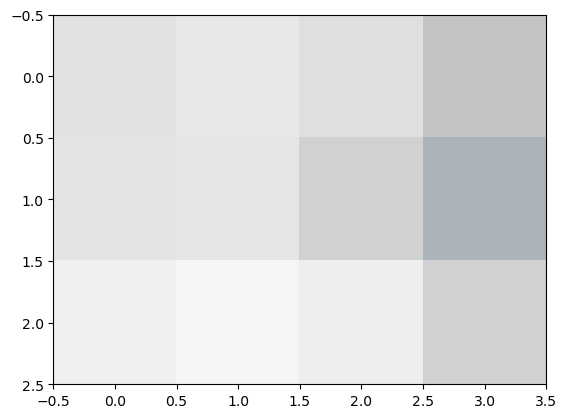

In [111]:
new=VisionTransformer(patch_size=4,output_dimension=256)
res=new.createImagePatches(image)
# res[0][0]
import matplotlib.pyplot as plt
plt.imshow(res[0][0])

In [14]:
import torch.optim as optim
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
input_size = 32 * 32 * 3  # CIFAR-10 image size is 32x32x3
hidden_size = 512
num_classes = 10

model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.view(images.size(0), -1)  # Flatten the image tensor
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.view(images.size(0), -1)  # Flatten the image tensor
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 1.8521
Epoch [2/10], Loss: 1.6783
Epoch [3/10], Loss: 1.5985
Epoch [4/10], Loss: 1.5593
Epoch [5/10], Loss: 1.5303
Epoch [6/10], Loss: 1.5018
Epoch [7/10], Loss: 1.4766
Epoch [8/10], Loss: 1.4622
Epoch [9/10], Loss: 1.4408
Epoch [10/10], Loss: 1.4289
Test Accuracy: 0.4775
